# DCGAN - Deep Convolutional GANs

# Importing the libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
tf.__version__

'2.15.0'

# Loading and preprocessing the dataset

In [2]:
(X_train, y_train), (_, _) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [3]:
X_train.shape

(60000, 28, 28)

In [4]:
28 * 28

784

In [5]:
y_train.shape

(60000,)

9


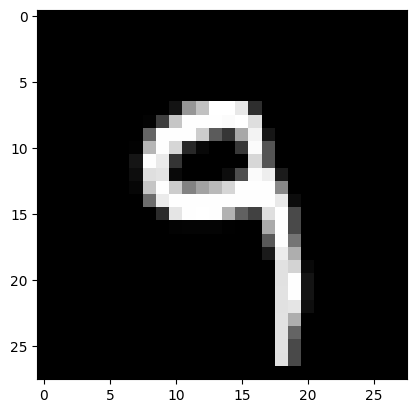

In [6]:
i = np.random.randint(0, 60000)
#print(i)
print(y_train[i])
plt.imshow(X_train[i], cmap='gray');

In [7]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')

In [8]:
X_train.shape

(60000, 28, 28, 1)

In [9]:
X_train[0].min(), X_train[0].max()

(0.0, 255.0)

In [10]:
X_train = (X_train - 127.5) / 127.5

In [11]:
X_train[0].min(), X_train[0].max()

(-1.0, 1.0)

In [12]:
buffer_size = 60000
batch_size = 256

In [13]:
buffer_size / batch_size # mini-batch

234.375

In [14]:
type(X_train)

numpy.ndarray

In [15]:
X_train = tf.data.Dataset.from_tensor_slices(X_train).shuffle(buffer_size).batch(batch_size)

In [16]:
type(X_train)

tensorflow.python.data.ops.batch_op._BatchDataset

In [17]:
X_train

<_BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

# Building the generator

- Batch normalization: https://keras.io/api/layers/normalization_layers/batch_normalization/
- Leaky Relu: https://keras.io/api/layers/activation_layers/leaky_relu/
- Funções de ativação: https://medium.com/@himanshuxd/activation-functions-sigmoid-relu-leaky-relu-and-softmax-basics-for-neural-networks-and-deep-8d9c70eed91e
- Padding: https://www.pico.net/kb/what-is-the-difference-between-same-and-valid-padding-in-tf-nn-max-pool-of-tensorflow

In [18]:
7 * 7 * 256

12544

In [19]:
# 100 -> 12544
def build_generator():
  network = tf.keras.Sequential()

  network.add(layers.Dense(units = 7*7*256, use_bias = False, input_shape=(100,)))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  network.add(layers.Reshape((7,7,256)))

  # 7x7x128
  network.add(layers.Conv2DTranspose(filters = 128, kernel_size = (5,5), padding = 'same', use_bias = False))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  # 14x14x64
  network.add(layers.Conv2DTranspose(filters = 64, kernel_size = (5,5), padding = 'same', strides = (2,2), use_bias = False))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  # 28x28x1
  network.add(layers.Conv2DTranspose(filters = 1, kernel_size = (5,5), padding = 'same', strides = (2,2), use_bias=True, activation='tanh'))

  network.summary()

  return network

In [20]:
generator = build_generator()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (Batch  (None, 12544)             50176     
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 7, 7, 128)         819200    
 anspose)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 7, 7, 128)         5

In [21]:
generator.input

<KerasTensor: shape=(None, 100) dtype=float32 (created by layer 'dense_input')>

In [22]:
noise = tf.random.normal([1, 100])
noise

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[-0.46547726,  0.67909616,  0.43196356,  0.6305448 ,  1.7920319 ,
         1.1225348 , -0.66960275, -0.38419914,  1.7636067 ,  0.77599895,
        -1.1560317 , -0.67992127, -0.8652753 , -0.7229021 , -1.1348511 ,
         0.78929216,  1.150491  , -2.02887   , -0.45172244, -1.5377283 ,
         0.3681566 , -0.21579666, -0.16782561,  0.10608673, -1.3606329 ,
        -1.6161911 ,  0.9999359 ,  0.32108724,  0.44454628, -0.572535  ,
         1.376659  , -1.2497289 , -0.44713736, -1.990587  , -0.02330715,
         0.15488218, -0.99424064, -0.28262952,  0.5050722 , -0.0639591 ,
         0.28901234, -0.4761945 ,  1.5777647 ,  0.07370368, -2.2894785 ,
        -0.21322788,  1.0035776 , -0.8607639 ,  1.0633295 ,  0.14552395,
         0.05134259,  0.8472641 , -1.2311602 ,  0.3569666 , -0.32830703,
        -1.0685284 ,  0.6818816 , -0.08683182,  1.5320565 , -0.79266804,
        -0.918186  , -2.770559  , -0.50382507,  0.44876334,  0.9168265 ,
 

In [23]:
generated_image = generator(noise, training = False)

In [24]:
generated_image.shape

TensorShape([1, 28, 28, 1])

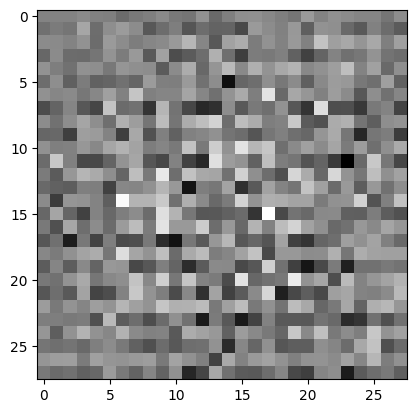

In [25]:
plt.imshow(generated_image[0, :,:,0], cmap='gray');

# Building the discriminator

- Dropout: https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf
- Conv2d x Conv2dTranspose: https://stackoverflow.com/questions/68976745/in-keras-what-is-the-difference-between-conv2dtranspose-and-conv2d

In [26]:
def build_discriminator():
  network = tf.keras.Sequential()

  # 14x14x64
  network.add(layers.Conv2D(filters = 64, strides = (2,2), kernel_size = (5,5), padding = 'same', input_shape = [28,28,1]))
  network.add(layers.LeakyReLU())
  network.add(layers.Dropout(0.3))

  # 7x7x128
  network.add(layers.Conv2D(filters = 128, strides = (2,2), kernel_size = (5,5), padding = 'same'))
  network.add(layers.LeakyReLU())
  network.add(layers.Dropout(0.3))

  network.add(layers.Flatten())
  network.add(layers.Dense(1))

  network.summary()

  return network

In [27]:
7 * 7 * 128

6272

In [28]:
discriminator = build_discriminator()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

In [29]:
discriminator.input

<KerasTensor: shape=(None, 28, 28, 1) dtype=float32 (created by layer 'conv2d_input')>

In [30]:
discriminator(generated_image, training = False) # logits

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00531349]], dtype=float32)>

In [31]:
tf.sigmoid(-0.00081761)

<tf.Tensor: shape=(), dtype=float32, numpy=0.4997956>

# Error calculation

- Logits: https://deepai.org/machine-learning-glossary-and-terms/logit

This method quantifies how well the discriminator is able to distinguish real images from fakes images. It compares the discriminator predictions on real images with an array of 1s and the discriminator predictions on fake (generated) images with an array of 0s.

In [32]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

In [39]:
# tf.ones_like([10,2,14])

In [40]:
def discriminator_loss(expected_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(expected_output), expected_output)   #### Creates a tensor of all ones that has the same shape as the input.
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

In [41]:
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

In [42]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001)

# Training the GAN and visualizing the results

- Based on: https://www.tensorflow.org/beta/tutorials/generative/dcgan
- @tf.function: https://www.tensorflow.org/guide/function#:~:text=You%20can%20use%20tf.,is%20required%20to%20use%20SavedModel%20.


In [43]:
X_train

<_BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

In [44]:
epochs = 100
noise_dimension = 100
number_of_images = 16

In [45]:
batch_size, noise_dimension

(256, 100)

In [46]:
@tf.function
def train(images):
  noise = tf.random.normal([batch_size, noise_dimension])
  #print(noise.shape)
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training = True)

    expected_output = discriminator(images, training = True)
    fake_output = discriminator(generated_images, training = True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(expected_output, fake_output)

  generator_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

In [52]:
tf.config.run_functions_eagerly(True)
X_train_batch = X_train.as_numpy_iterator().next()
train(X_train_batch)

In [51]:
test_images = tf.random.normal([number_of_images, noise_dimension])
test_images.shape

TensorShape([16, 100])

In [53]:
def train_gan(dataset, epochs, test_images):
  for epoch in range(epochs):
    #print(epoch)
    for image_batch in dataset:
      #print(image_batch.shape)
      train(image_batch)

    print('Epoch: ', epoch + 1)
    generated_images = generator(test_images, training = False)
    fig = plt.figure(figsize = (10,10))
    for i in range(generated_images.shape[0]):
      plt.subplot(4,4,i + 1)
      plt.imshow(generated_images[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')
    plt.show()

In [54]:
train_gan(X_train, epochs, test_images)

KeyboardInterrupt: 